In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, Printf
using TwoFAST, LaTeXStrings, ProgressMeter

In [3]:
FILE_F_MAP = "../test/datatest/F_REFERENCE.txt"
FILE_PS = "../test/datatest/file_pk.txt"
FILE_BACKGROUND = "../test/datatest/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)

I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../test/datatest/file_pk.txt"
# F window function input file : "../test/datatest/F_REFERENCE.txt"
# CLASS Background input file: "../test/datatest/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001465757 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095690664 Mpc/h_0
# 	 comoving z_eff = 0.15045636096023224 
# 	 Volume of the survey V_survey = 3.845366167995967e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
GaPSE.print_map_ξ_multipole(cosmo, "PSM_files/xi_auto_doppler_window_L0.txt", 
    "auto_doppler"; use_windows = true, N_log=1000, N_μs = 30, pr=false)

In [5]:
GaPSE.print_PS_multipole("PSM_files/xi_auto_doppler_window_L0.txt",
    "PSM_files/ps_auto_doppler_L0.txt";
     L = 0, N = 100, pr = false, int_s_min=1e-1, int_s_max=1e3)

In [6]:
my_table = readdlm("PSM_files/ps_auto_doppler_L0.txt", comments=true);
my_ks = convert(Vector{Float64}, my_table[:,1]);
my_pks = convert(Vector{Float64}, my_table[:,2]);

mattia_table = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/PS_doppler_doppler.txt")
mattia_ks = convert(Vector{Float64}, mattia_table[2:end, 1]);
mattia_pks = convert(Vector{Float64}, mattia_table[2:end, 2]);

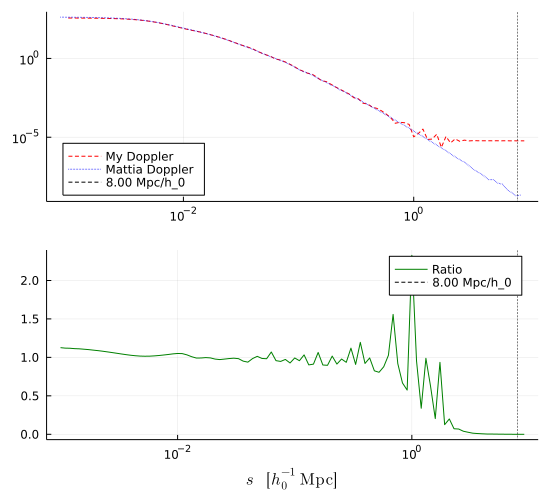

In [17]:
my_xs = my_ks
my_ys = my_pks
xs = mattia_ks
ys = mattia_pks

spline = Spline1D(xs, ys)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [my_xs[my_ys .> 0], xs[ys .> 0]], 
    [my_ys[my_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :dot], 
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(0.97,1.03), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
savefig(P, "PS_AutoDoppler_L0.pdf")
display(P)

In [35]:
function calc_quadgk(k, f, kmin, kmax; rtol=1e-2, atol=0.0)
    en = 1e12
    res1 = quadgk( x -> en * f(x) * x * (sin(k*x) - 2), 
        kmin, kmax ; rtol = rtol, atol=atol)[1]
    res2 = quadgk( x -> 2 * en * f(x) * x , 
        kmin, kmax ; rtol = rtol, atol=atol)[1]
    res = res1 + res2
    return res / en  / k * 4 * π^2
end;

function calc_twofast(f, kmin, kmax; N = 1024)
    ks, pks = xicalc(s -> 2 * π^2 * f(s), 0, 0;
        N = N, kmin = kmin, kmax = kmax, r0 = 1 / kmax) ;
    return ks, pks ./ π
end;

In [36]:
my_xi_table = readdlm("PSM_files/xi_auto_doppler_window_L0.txt", comments=true);
my_ss = convert(Vector{Float64}, my_xi_table[:,1]);
my_xis = convert(Vector{Float64}, my_xi_table[:,2]);
my_spline = Spline1D(my_ss, my_xis);

In [37]:
my_2fast_ks, my_2fast_pks = calc_twofast(my_spline, 1e-1, 1e3; N = 50);

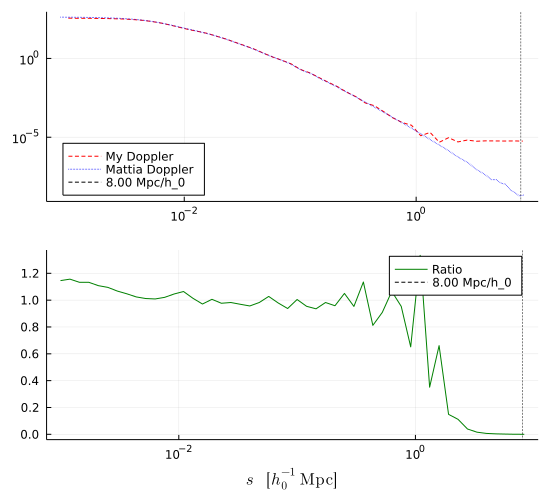

In [38]:
my_xs = my_2fast_ks
my_ys = my_2fast_pks 
xs = mattia_ks
ys = mattia_pks

spline = Spline1D(xs, ys)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [my_xs[my_ys .> 0], xs[ys .> 0]], 
    [my_ys[my_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :dot], 
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(0.97,1.03), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
savefig(P, "PS_AutoDoppler_L0.pdf")
display(P)